# Unsupervised Learning Project: Spotify Songs Clustering

## Objective
The main objective of this clustering algorithm is to be later on used for similar song recommendation. I will be using Dimentionality reduction with clustering algorithms.

### Import Packages

In [22]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import nltk
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler
from sklearn.manifold import TSNE, MDS
from umap.umap_ import UMAP
import os
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD, PCA,KernelPCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
import hdbscan
from sklearn.metrics import silhouette_score
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')



## Dataset
[Dataset Link](https://www.kaggle.com/datasets/rishabhpancholi1302/spotify-most-popular-songs-dataset/data)

This dataset contains a collection of the most popular songs on Spotify, along with various attributes that can be used for music analysis and recommendation systems. It includes audio features, lyrical details, and general metadata about each track, making it an excellent resource for machine learning, data science, and music analytics projects.

Each song in the dataset includes the following features:

🎧 Audio Features (Extracted from Spotify API):

- Danceability – How suitable a track is for dancing (0.0 – 1.0).
- Energy – Intensity and activity level of a song (0.0 – 1.0).
- Loudness – Overall loudness in decibels (dB).
- Speechiness – Presence of spoken words in the track (0.0 – 1.0).
- Acousticness – Probability that a track is acoustic (0.0 – 1.0).
- Instrumentalness – Predicts if a track is instrumental (0.0 – 1.0).
- Liveness – Probability of a live audience (0.0 – 1.0).
- Valence – Musical positivity or happiness (0.0 – 1.0).
- Tempo – Beats per minute (BPM) of the track.
- Key & Mode – Musical key and mode (major/minor).

📝 Lyrics-Based Features:
- Lyrics Text – Full lyrics of the song (if available).

🎶 General Song Information:
- Track Name – Name of the song.
- Artist(s) – Performing artist(s).
- Album Name – Album the track belongs to.
- Release Year – Year when the song was released.
- Genre – Song’s primary genre classification.
- Popularity Score – Spotify popularity metric (0 – 100).

Already Preprocessed Columns:
- tags: lyrices stopwords and punctuations has been removed.
- tags_tokenized: tags has been split into list
- doc_vector: Word2Vec embedding has been used for getting tokenized words embeddings. size: (300,)
- combined_vector: 11 Numerical featured has been combined with doc_vector giving size of (311,) 
- cluster : A column has been added by the dataset provider based on his Kmeans clustering. (That I will not be using)
- image_url: url of the spotify song image
- spotify_url: track spotify url


## EDA

EDA will be consisting of:
- Column names and unique values with each values
- Pair plot to have a better understanding how each column define different clusters
- Heatmap of numerical columns for understanding impact of each column on one another.
- Looking for NA values and replacing them.
- Finding Important features and reducing dimentions for computational efficiency and finding higher dimentions feature relations.
- Getting Insights from different graphs.
- Has used One Hot Encoding, normlization, standard scaling like techniques.
- Used SentenceTransformer for getting semantic meaning of the lyrics or tags.


### Loading Dataset

In [2]:
data = pd.read_csv("songs.csv",index_col= 0)
data.head(3)

track_id                    track_name  track_artist  \
0  6oJ6le65B3SEqPwMRNXWjY                   higher love          Kygo   
1  3yNZ5r3LKfdmjoS3gkhUCT  bad guy (with justin bieber)  Billieeilish   
2  0qc4QlcCxVTGyShurEv1UU      post malone (feat. rani)      Samfeldt   

   track_popularity track_album_release_date playlist_genre  danceability  \
0          0.500000               2019-06-28            Pop      0.632680   
1          0.318182               2019-07-11            Pop      0.602614   
2          0.318182               2019-05-24            Pop      0.498039   

     energy       key  loudness  ...  track_artist_merged  \
0  0.667346  0.727273  0.680129  ...                 kygo   
1  0.425904  0.000000  0.504094  ...        billie eilish   
2  0.628716  0.636364  0.821136  ...            sam feldt   

                                              lyrics    artist_name  \
0  ['bring', 'me', 'higher', 'love,', 'love', '',...           Kygo   
1  ['yeah,', 'yeah', '', 'oh,', 'ah', '', 'white'...  Billie Eilish   
2  ['one', 'more', 'drink,', 'got', 'one', 'more'...      Sam Feldt   

                                                tags  \
0  bring higher love love bring higher love think...   
1  yeah yeah oh ah white shirt red bloody nose sl...   
2  one drink got one bacardi one dance afterparty...   

                                      tags_tokenized  \
0  ['bring', 'higher', 'love', 'love', 'bring', '...   
1  ['yeah', 'yeah', 'oh', 'ah', 'white', 'shirt',...   
2  ['one', 'drink', 'got', 'one', 'bacardi', 'one...   

                                          doc_vector  \
0  [-0.1148182   0.27755967  0.27891365  0.143460...   
1  [-2.95320839e-01 -2.59309914e-03  3.84592146e-...   
2  [-0.1616459   0.21872164  0.3755187   0.116120...   

                                     combined_vector cluster  \
0  [-0.1148182   0.27755967  0.27891365  0.143460...       3   
1  [-2.95320839e-01 -2.59309914e-03  3.84592146e-...       1   
2  [-0.1616459   0.21872164  0.37551871  0.116120...       3   

                                           image_url  \
0  https://i.scdn.co/image/ab67616d0000b2737c8977...   
1  https://i.scdn.co/image/ab67616d0000b273a69b8b...   
2  https://i.scdn.co/image/ab67616d0000b27354de16...   

                                         spotify_url  
0  https://open.spotify.com/track/6oJ6le65B3SEqPw...  
1  https://open.spotify.com/track/3yNZ5r3LKfdmjoS...  
2  https://open.spotify.com/track/0qc4QlcCxVTGySh...  

[3 rows x 27 columns]

In [3]:
data.drop(columns=['image_url','spotify_url'],axis=1, inplace=True)
data.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_release_date', 'playlist_genre', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'track_artist_merged', 'lyrics',
       'artist_name', 'tags', 'tags_tokenized', 'doc_vector',
       'combined_vector', 'cluster'],
      dtype='object')

#### Observation

- Dropped unncessary features which will not be used,'image_url','spotify_url' as they will not be contributing anything.

In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 0 to 899
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  900 non-null    object 
 1   track_name                900 non-null    object 
 2   track_artist              900 non-null    object 
 3   track_popularity          900 non-null    float64
 4   track_album_release_date  900 non-null    object 
 5   playlist_genre            900 non-null    object 
 6   danceability              900 non-null    float64
 7   energy                    900 non-null    float64
 8   key                       900 non-null    float64
 9   loudness                  900 non-null    float64
 10  mode                      900 non-null    float64
 11  speechiness               900 non-null    float64
 12  acousticness              900 non-null    float64
 13  liveness                  900 non-null    float64
 14  valence        

#### Obsevation
- No null values has been found
- doc_vector and combined_vector is in string format we have to convert them into np.array.
- we have 11 Numerically Scaled features, 1 integer feature duration

In [5]:
for column in data.columns:
    print(column, len(data[column].unique()))

track_id 900
track_name 900
track_artist 468
track_popularity 23
track_album_release_date 467
playlist_genre 6
danceability 424
energy 474
key 12
loudness 844
mode 2
speechiness 577
acousticness 664
liveness 462
valence 550
tempo 876
duration_ms 887
track_artist_merged 468
lyrics 899
artist_name 468
tags 900
tags_tokenized 900
doc_vector 900
combined_vector 900
cluster 5


### Observation 
- There are 468 different artist, we could also see artist_name, track_artist_merged, and track_artist all have same feature with different preprocessing.
- we have 2 modes
- 6 genre
- 12 keys

In [6]:
import ast
def convert_to_numpy_array(array_str):
    # Remove the brackets and split by space, then convert to float
    array_str = array_str.strip('[]')  # Remove the square brackets
    return np.array([float(x) for x in array_str.split()])  # Convert to float and create a NumPy array


# Convert the specified columns to NumPy arrays
data['doc_vector'] = data['doc_vector'].apply(convert_to_numpy_array)
data['combined_vector'] = data['combined_vector'].apply(convert_to_numpy_array)

print('combined_vector','doc_vector')
for i in range(10):
    print(len(data['combined_vector'][i]),len(data['doc_vector'][i]))

combined_vector doc_vector
311 300
311 300
311 300
311 300
311 300
311 300
311 300
311 300
311 300
311 300


#### Observation 

- We get to know combined vector is a mix of 11 floating scaled values and doc_vector as 11 values are only added to it and we could also verify that by comparing starting 300 values with doc_vector and last 11 with the  floating scaled numerical column data

In [7]:
# Selecting only numerical columns
numerical_cols = list(data.select_dtypes(include=['number']).columns)
categorical_cols = list(data.columns.difference(numerical_cols))
categorical_cols, numerical_cols


(['artist_name',
  'combined_vector',
  'doc_vector',
  'lyrics',
  'playlist_genre',
  'tags',
  'tags_tokenized',
  'track_album_release_date',
  'track_artist',
  'track_artist_merged',
  'track_id',
  'track_name'],
 ['track_popularity',
  'danceability',
  'energy',
  'key',
  'loudness',
  'mode',
  'speechiness',
  'acousticness',
  'liveness',
  'valence',
  'tempo',
  'duration_ms',
  'cluster'])

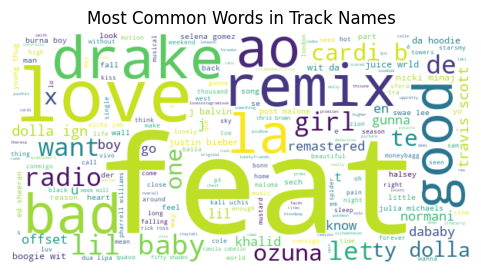

In [8]:
text = "".join(data['track_name'])
wordcloud = WordCloud(width = 600, height=300, background_color = 'white').generate(text)
plt.figure(figsize = (6,3))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.title("Most Common Words in Track Names")
plt.show()

#### Observation 
- Feat, Love, Drake are most used words and we could also notice the other most common words for the songs.

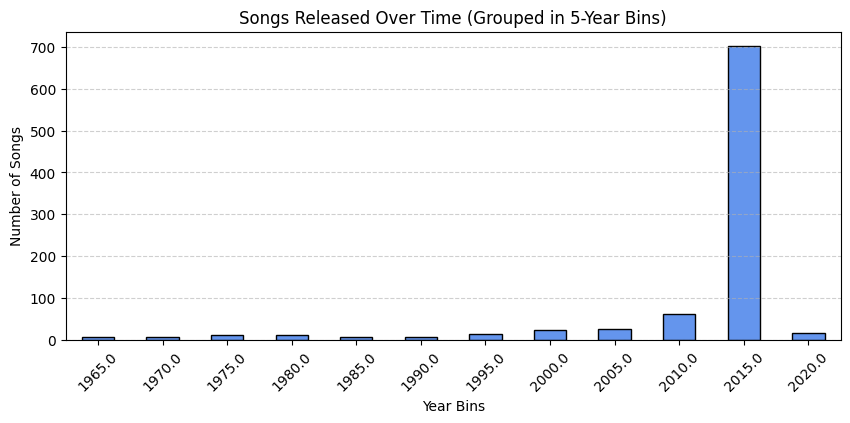

In [9]:
# Count of songs released per year
data['track_album_release_date']= pd.to_datetime(data['track_album_release_date'], errors='coerce')
data['year'] = data['track_album_release_date'].dt.year
yearly_songs = data.groupby('year')['track_id'].count()
# Define bin size (change to 5, 10, etc., based on dataset size)
bin_size = 5

# Create bins and labels
data['year_bin'] = (data['year'] // bin_size) * bin_size  # Groups into bins like 1990-1995, 1995-2000, etc.

# Count songs per bin
yearly_songs_binned = data.groupby('year_bin')['track_id'].count()

# Plot
plt.figure(figsize=(10, 4))
yearly_songs_binned.plot(kind="bar", color="cornflowerblue", edgecolor="black")

plt.title(f"Songs Released Over Time (Grouped in {bin_size}-Year Bins)")
plt.xlabel("Year Bins")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

#### Observation
- Most songs has been released in **2015-2020** spam i.e **700**
- We could also see increasing trend of songs and emerging artist through it.

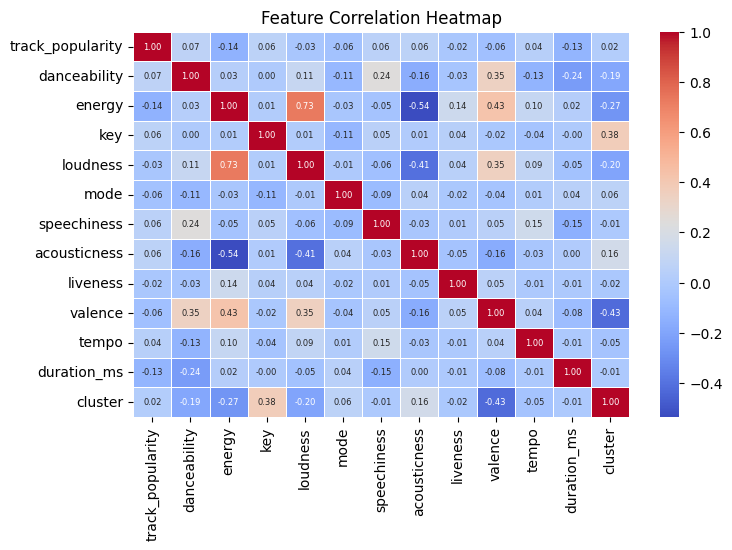

In [10]:
plt.figure(figsize=(8,5))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f",linewidths=0.5, annot_kws={"size": 6})
plt.title("Feature Correlation Heatmap")
plt.show()

#### Observation 
- Loudness is highly related positively with Energy, and negatively with accousticness
- Danceability is highly related with valence
- Key and valence plays an important role in clustering for the previous model.

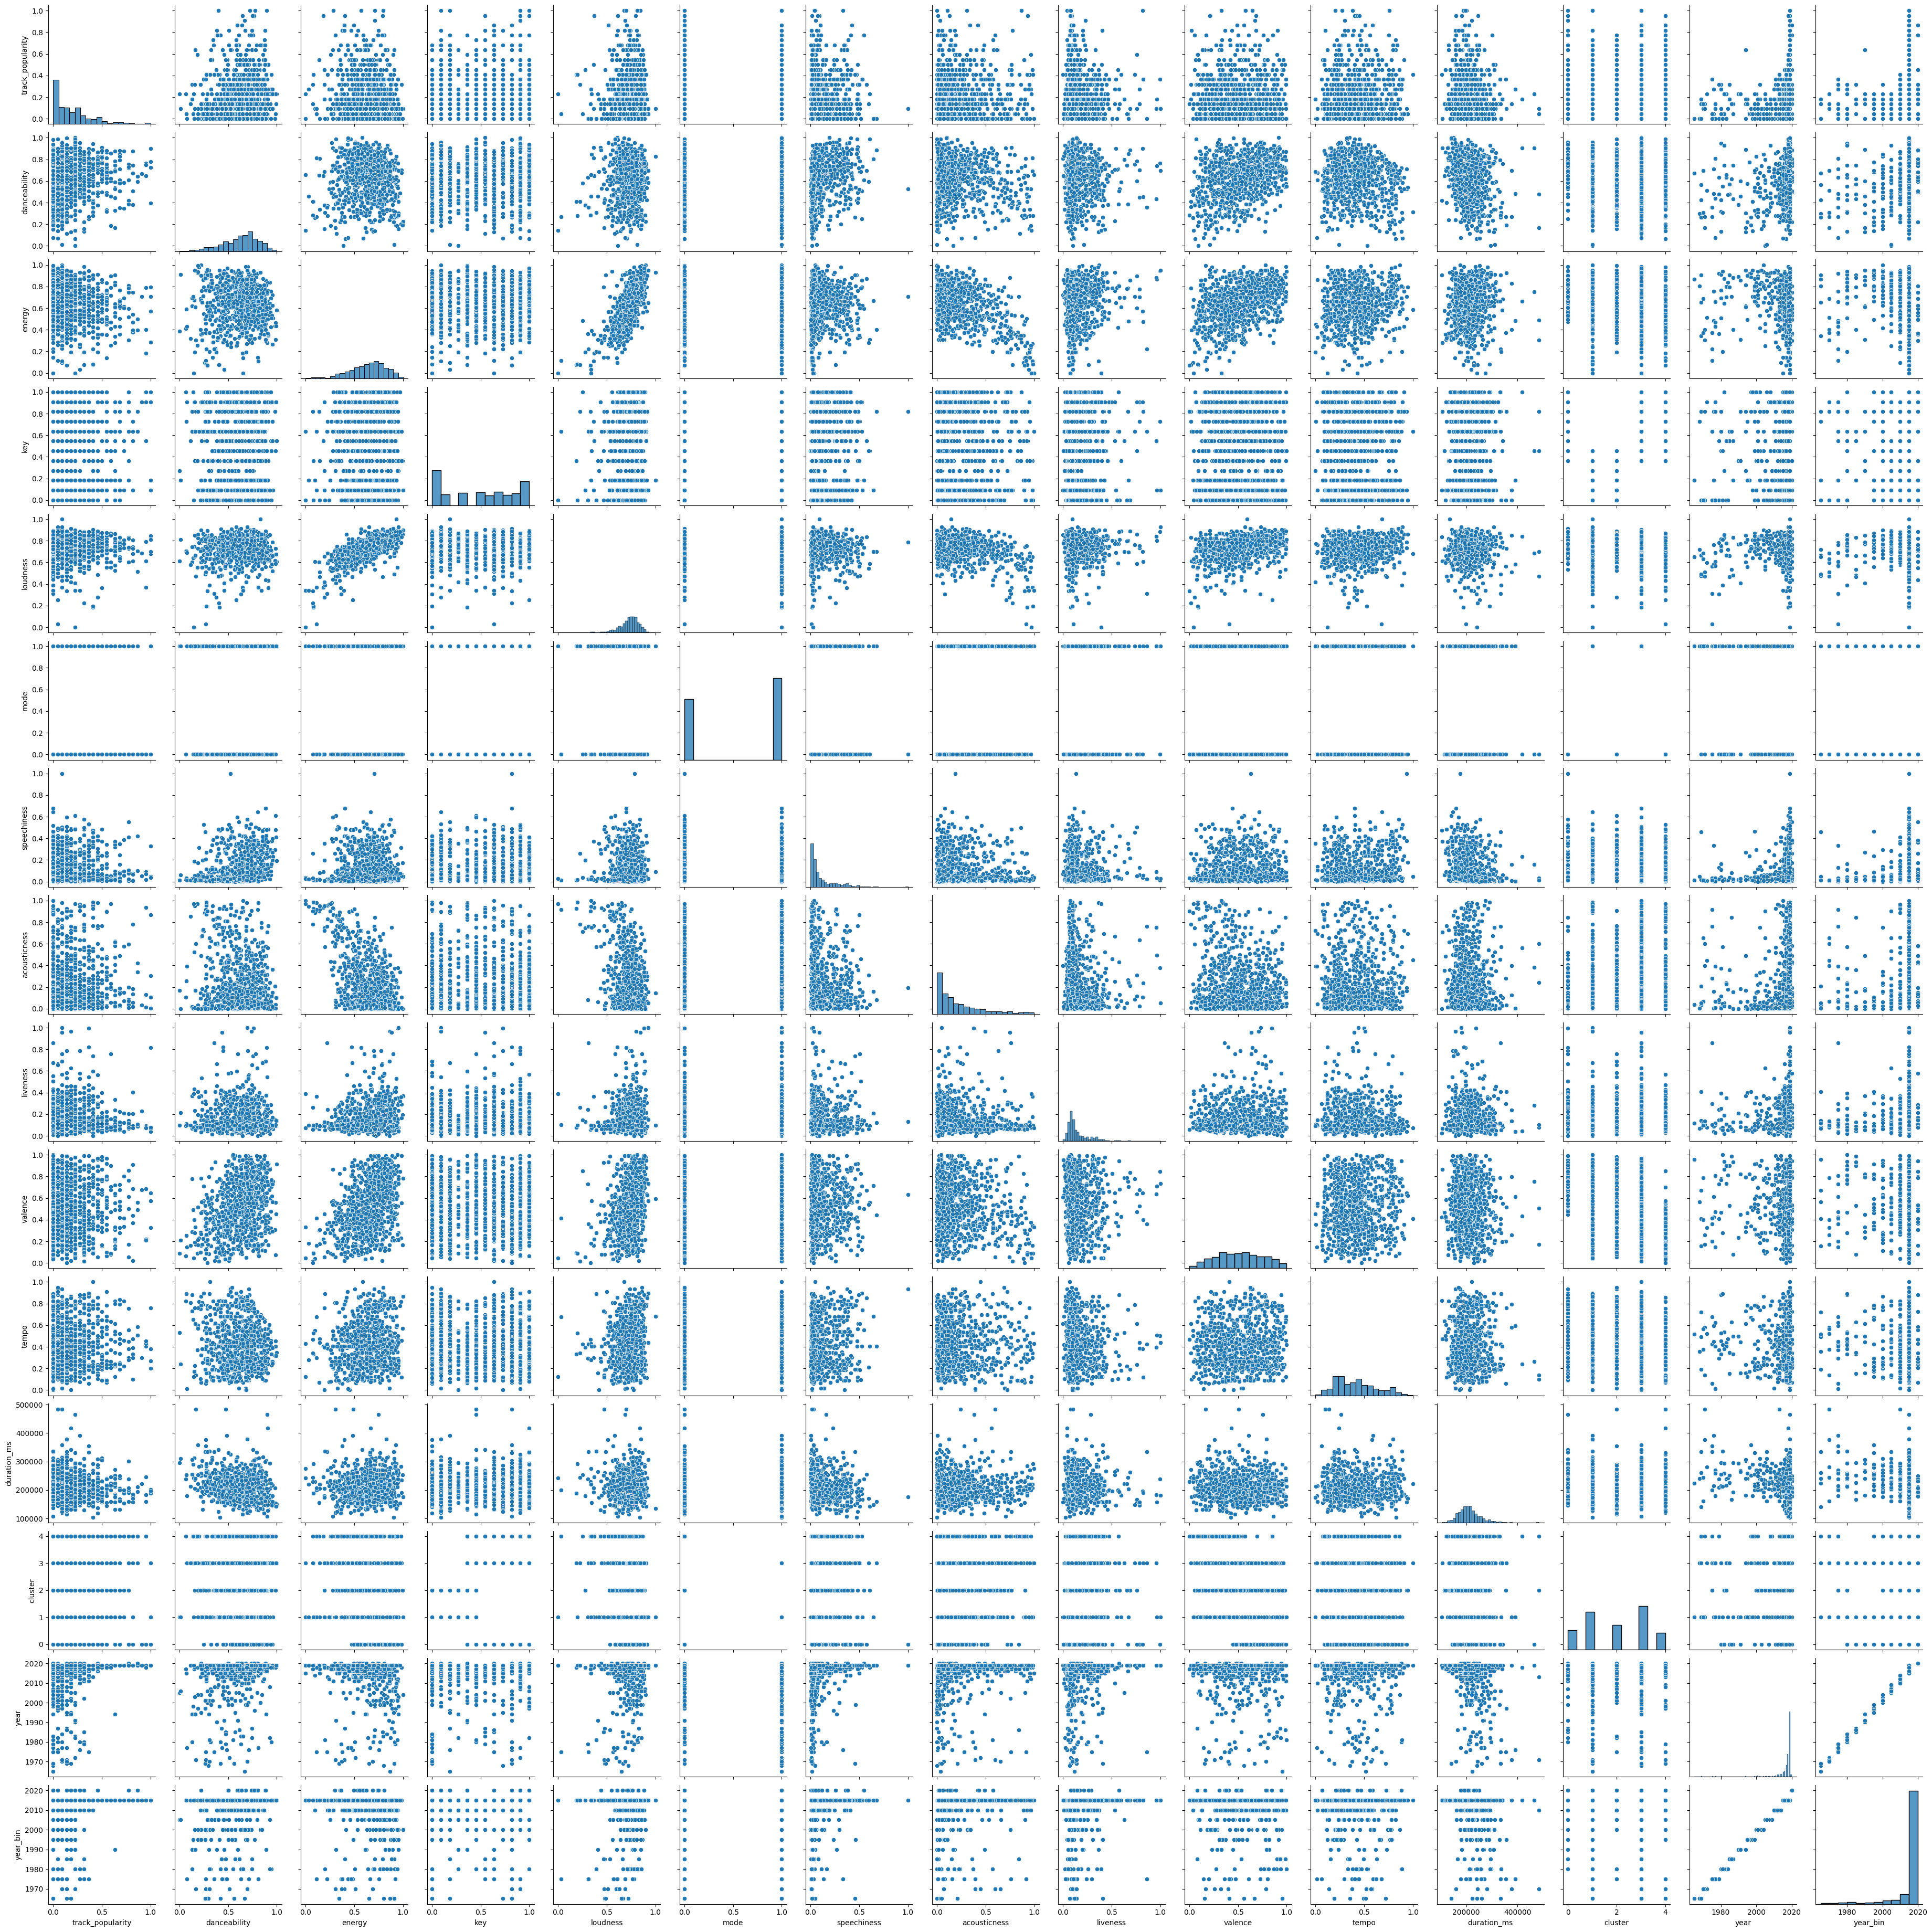

In [11]:
sns.pairplot(data.drop(columns=['doc_vector','combined_vector'],axis=1))

#### Observation 
- With 2D it won't be easy to cluster with have to go to higher dimentions.

In [12]:
## Seperating Combined vector for analysis.
embedding_matrix = np.vstack(data["combined_vector"].values)
print(embedding_matrix.shape)  # (n, 311)
embedding_matrix

(900, 311)


array([[-0.1148182 ,  0.27755967,  0.27891365, ...,  0.08600444,
         0.39136969,  0.29060535],
       [-0.29532084, -0.0025931 ,  0.38459215, ...,  0.10293029,
         0.68763418,  0.50837382],
       [-0.1616459 ,  0.21872164,  0.37551871, ...,  0.0902359 ,
         0.65650494,  0.31443855],
       ...,
       [-0.12616959,  0.19998066,  0.29130945, ...,  0.13255051,
         0.35702018,  0.31791831],
       [-0.12194037,  0.32961181,  0.34245756, ...,  0.21083254,
         0.43752684,  0.30454539],
       [-0.08236136,  0.28211612,  0.30290502, ...,  0.17909658,
         0.45899528,  0.61985913]])

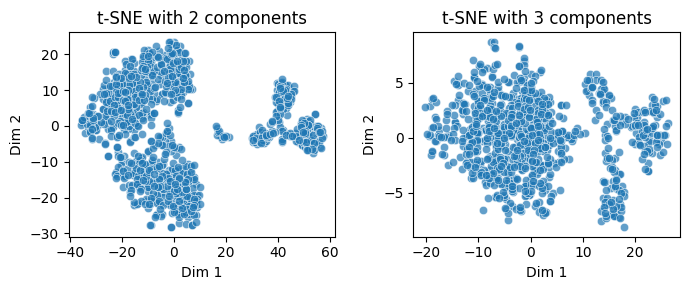

In [13]:
def plot_tsne(X_data):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    axes = axes.ravel()  # Flatten the array of axes for easy indexing

    for i, n_comp in enumerate(range(2, 4)):
        # Applying t-SNE
        tsne = TSNE(n_components=n_comp, random_state=42)
        X_tsne = tsne.fit_transform(X_data)

        # Plot only the first two dimensions
        ax = axes[i]
        sns.scatterplot(
            x=X_tsne[:, 0],
            y=X_tsne[:, 1],
            alpha=0.7,
            ax=ax
        )
        ax.set_title(f"t-SNE with {n_comp} components")
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")

    plt.tight_layout()
    plt.show()
plot_tsne(X_data=embedding_matrix)

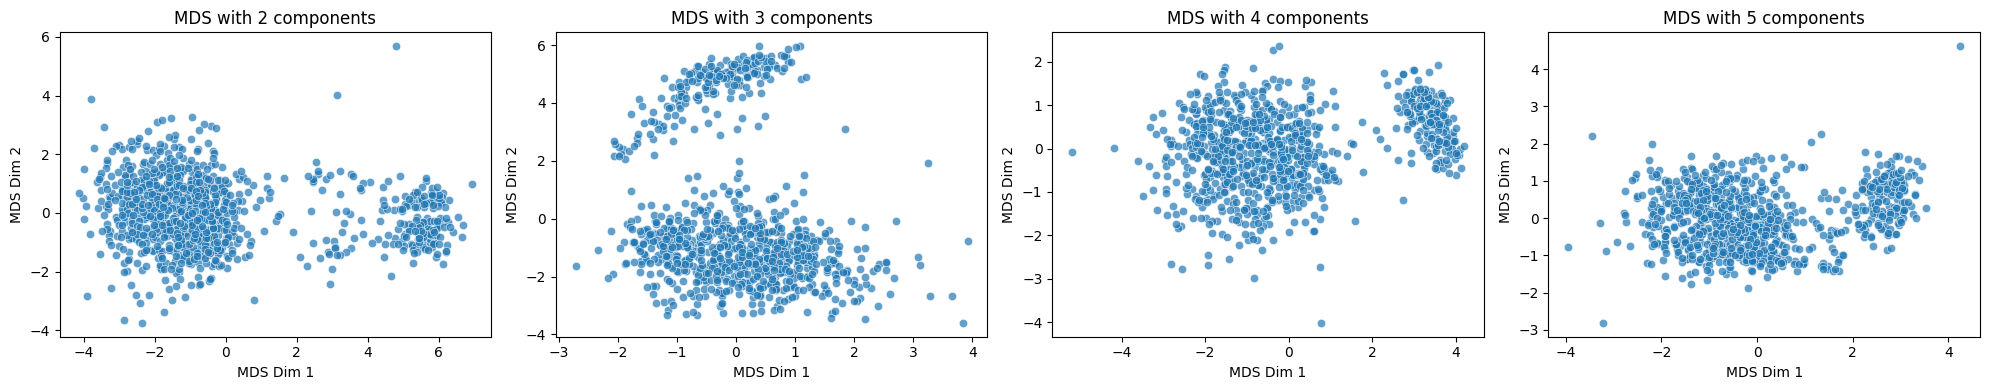

In [14]:
def plot_msd(X_data):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    axes = axes.ravel()  # Flatten the array of axes for easy indexing

    for i, n_comp in enumerate(range(2, 6)):
        # Applying t-SNE
        mds = MDS(n_components=n_comp, random_state=42)
        X_mds = mds.fit_transform(embedding_matrix)
               
        ax = axes[i]
        sns.scatterplot(
            x=X_mds[:, 0],  # First dimension
            y=X_mds[:, 1],  # Second dimension
            palette='viridis',
            alpha=0.7,
            ax=ax
        )
        ax.set_title(f"MDS with {n_comp} components")
        ax.set_xlabel("MDS Dim 1")
        ax.set_ylabel("MDS Dim 2")

    plt.tight_layout()
    plt.show()
plot_msd(embedding_matrix)


#### Observation 
- We could have 2-4 clusters in our data based on 2D plot w.r.t. combined_vector  with both dimentionality reduction techniques.
- But we have to keep in mind that MDS and TSNE does not work well with semantic data, they are best for distanced based algorithm.

### Observation And Insights 

- Energy, Accousticness, Loudness are inter-related as mellow songs would have more accoustic sounds, less loudness and energy usually
- high loudness results in more energy in songs
- 6 types of genre, 12 types of key or notes are there
- We would need higher dimentions and understanding of song features for similar song recommendation and clustering as 2D won't be much useful.

### Pre-Processing and, Model scoring and defining

- **genre**, **artist** has been **One Hot Encoded** using pd.get_dummies.
- Numerical Data has been seperated.
- To get semantic features **SentenceTransformer** is being used with **tags** then **normalised** using **l2**.
- Numerical data is linear so used PCA having 5 component.
- Hot Encoded values has been reduced to 20 for artist and 1 for genre using **TruncatedSVD**.
- **UMAP** is used to reduced features to 30 for getting semantic relation with higher dimentions as there were 300+ tags.

I created 2 Data:
- One with without reducing any features just normalised and scaled.
- 2nd with reduced with different techniques.

In [33]:
def plot_kmeans(X_data,name):
    intertias = []
    for k in range(2, 20):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_data)
        intertias.append(kmeans.inertia_)
    plt.figure(figsize=(3,3))
    plt.plot(range(2, 20), intertias)
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Intertia")
    plt.title(f"Elbow Method for Optimal k for {name}")
    plt.show()

In [16]:
def DBSCAN_train(X_data,name):
    # Example values (Replace with optimal found from K-Distance plot)
    eps_values = [0.05, 0.1, 0.2, 0.3,0.4,0.5,0.7,0.8]  # Adjust based on dataset
    min_samples_values = [5, 10, 20,50,80,100]  # Try values based on data density

    best_score = -1
    best_params = None
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')  # Change metric if needed
            labels = dbscan.fit_predict(X_data)
            
            # Ignore if only one cluster is formed (or all noise)
            if len(set(labels)-{1}) > 1:
                score = silhouette_score(X_data, labels)
                # print(f"eps={eps}, min_samples={min_samples}, silhouette_score={score:.5f}, clusters={len(set(labels) - {1})}")
                
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
                    best_cluster_size= len(set(labels) - {1})
    if best_params:
        print(f"\n{name} Best DBSCAN Params: eps={best_params[0]}, min_samples={best_params[1]}, silhouette_score={best_score:.3f}, Cluster:{best_cluster_size}")

In [34]:
def AgglomerativeClustering_plot(X_data, name):
    scores=[]
    n_comps=[]
    for n in range(2,50):
        agg= AgglomerativeClustering(n_clusters=n)
        cluster_labels = agg.fit_predict(X_data)
            
        # Ignore Silhouette Score for DBSCAN if many points are marked as noise (-1)
        if len(set(cluster_labels)) > 1:
            score = silhouette_score(X_data, cluster_labels)
            n_comps.append(n)
            scores.append(score)

    plt.figure(figsize=(3,3))
    plt.plot(n_comps,scores)
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title(f"Scores for Optimal k for {name}")
    plt.show()

In [ ]:
#Data Preprocessing
model = SentenceTransformer('all-MiniLM-L6-v2')

df_numerical = data[numerical_cols]
pca_numerical = PCA(n_components=5, random_state=42)
numerical_reduced = pca_numerical.fit_transform(df_numerical)


# Handling Categorical Columns (One-Hot Encoding 'playlist_genre')
df_genre = pd.get_dummies(data['playlist_genre'], drop_first=True)
df_artist_ohe = pd.get_dummies(data['artist_name'], prefix='artist', drop_first=True)
artist_svd_onehot = TruncatedSVD(n_components=20, random_state=42)  
artist_reduced = artist_svd_onehot.fit_transform(df_artist_ohe)
genre_svd_onehot = TruncatedSVD(n_components=1, random_state=42)  
genre_reduced = genre_svd_onehot.fit_transform(df_genre)


# Handling Text Columns using TF-IDF (lyrics, tags)
tag_embeddings = np.vstack(data['tags'].apply(lambda x: model.encode(str(x))))
normalizer = Normalizer(norm='l2')
embedding_normalized = normalizer.fit_transform(tag_embeddings)
umap_embeddings = UMAP(n_components=30, random_state=42, metric='cosine')
embeddings_reduced = umap_embeddings.fit_transform(tag_embeddings)

# Convert to DataFrame 
df_tags = pd.DataFrame(embedding_normalized, columns=[f'tag_{i}' for i in range(embedding_normalized.shape[1])])

#Unreduced Data
df_final = pd.concat([df_numerical, df_genre, df_artist_ohe, df_tags], axis=1)
 
#Reduced Data
X = np.concatenate([
    numerical_reduced,
    genre_reduced,
    artist_reduced,
    embeddings_reduced
], axis=1)

print(f"Final Shape After Merging: {X.shape}") 
df_final.describe()



Final Shape After Merging: (900, 56)


track_popularity  danceability      energy         key    loudness  \
count        900.000000    900.000000  900.000000  900.000000  900.000000   
mean           0.199545      0.623394    0.640775    0.484444    0.726726   
std            0.199525      0.183919    0.181130    0.334353    0.111564   
min            0.000000      0.000000    0.000000    0.000000    0.000000   
25%            0.045455      0.504248    0.527578    0.181818    0.681972   
50%            0.136364      0.652288    0.664127    0.454545    0.743644   
75%            0.318182      0.749346    0.777873    0.818182    0.798564   
max            1.000000      1.000000    1.000000    1.000000    1.000000   

             mode  speechiness  acousticness    liveness     valence  ...  \
count  900.000000   900.000000    900.000000  900.000000  900.000000  ...   
mean     0.574444     0.115008      0.225910    0.160050    0.518995  ...   
std      0.494702     0.133004      0.238884    0.139023    0.237509  ...   
min      0.000000     0.000000      0.000000    0.000000    0.000000  ...   
25%      0.000000     0.023636      0.043808    0.077727    0.334210  ...   
50%      1.000000     0.055262      0.140391    0.107691    0.515887  ...   
75%      1.000000     0.158157      0.326666    0.194965    0.705882  ...   
max      1.000000     1.000000      1.000000    1.000000    1.000000  ...   

          tag_374     tag_375     tag_376     tag_377     tag_378     tag_379  \
count  900.000000  900.000000  900.000000  900.000000  900.000000  900.000000   
mean     0.032464   -0.001176   -0.000180    0.083935   -0.004169    0.008147   
std      0.034599    0.043137    0.034469    0.035275    0.035168    0.034403   
min     -0.073599   -0.125999   -0.128981   -0.057180   -0.111977   -0.102823   
25%      0.009423   -0.031147   -0.023066    0.060304   -0.027868   -0.014743   
50%      0.033452   -0.002556   -0.000836    0.083880   -0.004145    0.006997   
75%      0.057569    0.030092    0.021599    0.109180    0.020649    0.032362   
max      0.154743    0.136306    0.124025    0.207000    0.116897    0.106140   

          tag_380     tag_381     tag_382     tag_383  
count  900.000000  900.000000  900.000000  900.000000  
mean     0.038920    0.015560    0.002120   -0.067236  
std      0.040891    0.047144    0.041019    0.038570  
min     -0.061633   -0.103175   -0.184510   -0.191904  
25%      0.009916   -0.019485   -0.025272   -0.094228  
50%      0.037997    0.012432    0.002483   -0.070262  
75%      0.066414    0.047103    0.031173   -0.043726  
max      0.193916    0.158755    0.114898    0.060328  

[8 rows x 397 columns]

#### Observation 
- Non reduced featured has much variance in data, with numerical features scaled from 0-1 and semantic ones are very low.

In [19]:
# Standardizing the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Using kpca on Non Reduced set with different kernels

kpca = KernelPCA(n_components=50, kernel='poly', gamma=0.3, random_state=42)
pol_X_kpca = kpca.fit_transform(df_final)
kpca = KernelPCA(n_components=25, kernel='cosine', gamma=0.3, random_state=42)
cos_X_kpca = kpca.fit_transform(df_final)
kpca = KernelPCA(n_components=50, kernel='rbf', gamma=0.1, random_state=42)
rbf_X_kpca = kpca.fit_transform(df_final)


### Modelling, Training, Plotting and Scoring

- Used Kmeans for spherical cluster in higher dimentions with PCA and Kpca.
- Used DBSCAN for irregular shape and noises like data.
- Used HDBSCAN for high density clusters.
- Used AgglomerativeClustering for Tree based clustering approach based on genre and artist.

df_final Silhouette Score (Ignoring Noise): -0.04516269 
clusters: 134


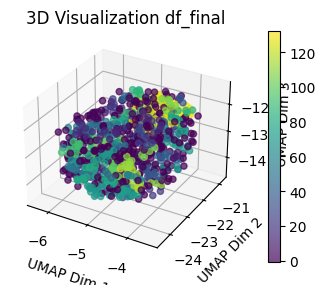

embedding_matrix Silhouette Score (Ignoring Noise): 0.298826 
clusters: 85


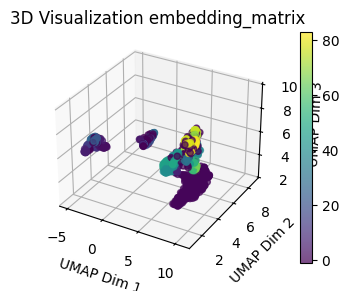

X_scaled Silhouette Score (Ignoring Noise): 0.4106002 
clusters: 114


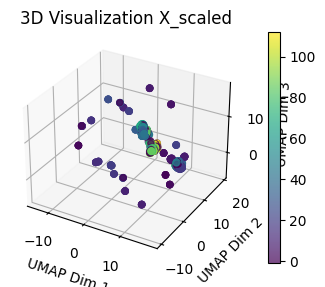

X Silhouette Score (Ignoring Noise): 0.6556491 
clusters: 56


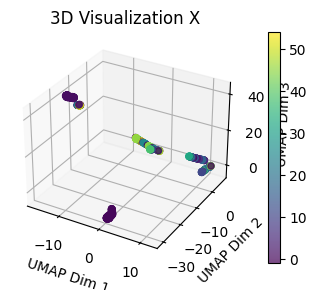

pol_X_kpca Silhouette Score (Ignoring Noise): 0.97337943 
clusters: 2


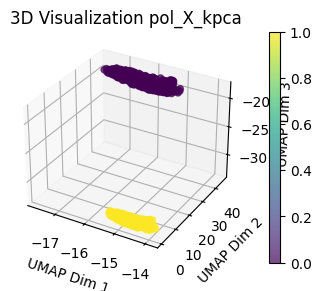

cos_X_kpca Silhouette Score (Ignoring Noise): 0.555738 
clusters: 79


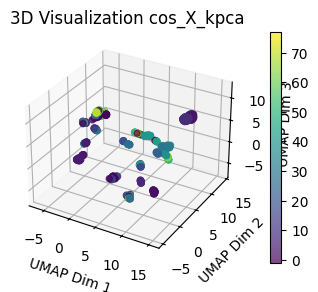

rbf_X_kpca Silhouette Score (Ignoring Noise): 0.31911534 
clusters: 9


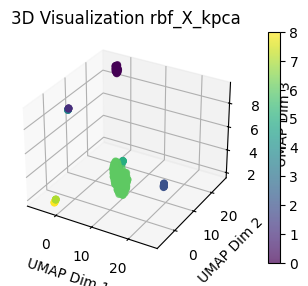

In [23]:
### Reducing every dataset to 3D using UMAP

def plot_3d(X_data,name):
    # Reduce dimensionality to 3D
    umap_3d = UMAP(n_components=3, random_state=42, metric='cosine')
    X_umap_3d = umap_3d.fit_transform(X_data)

    # Scatter plot in 3D
    fig = plt.figure(figsize=(7, 3))
    ax = fig.add_subplot(111, projection='3d')

    hdb = hdbscan.HDBSCAN(min_cluster_size=2, metric="euclidean")
    hdb_labels = hdb.fit_predict(X_umap_3d)

    if len(set(hdb_labels)) > 1: 
        sil_score = silhouette_score(X_umap_3d, hdb_labels)
        print(name, "Silhouette Score (Ignoring Noise):", sil_score, "\nclusters:",len(set(hdb_labels)) )

    scatter = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2], c=hdb_labels ,cmap="viridis", alpha=0.7)
    ax.set_title(f"3D Visualization {name}")
    ax.set_xlabel("UMAP Dim 1")
    ax.set_ylabel("UMAP Dim 2")
    ax.set_zlabel("UMAP Dim 3")
    plt.colorbar(scatter)
    plt.show()

### Different pre-processed data for getting better result and approach
plot_3d(df_final,'df_final')
plot_3d(embedding_matrix,'embedding_matrix')
plot_3d(X_scaled,'X_scaled')
plot_3d(X,'X')
plot_3d(pol_X_kpca,'pol_X_kpca')
plot_3d(cos_X_kpca,'cos_X_kpca')
plot_3d(rbf_X_kpca,'rbf_X_kpca')

#### Observation 
- Non-reduced with kpca poly kernel has highest scoring but it diverts data into 2 clusters only.
- Non-reduced with kpca rbf kernel has high scoring and also gives 11 different clusters.

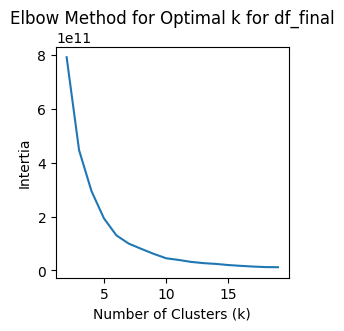

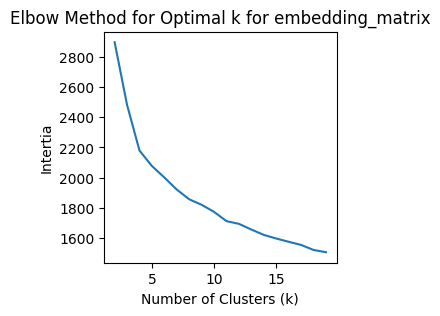

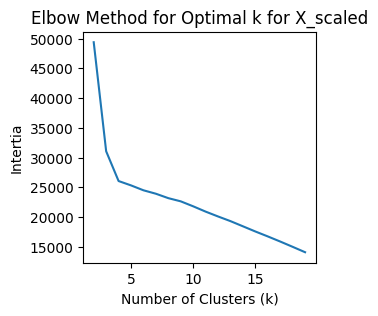

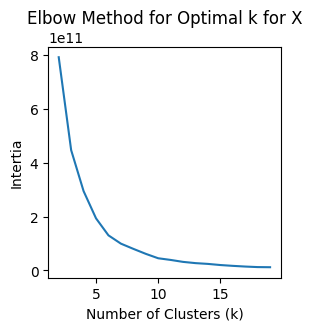

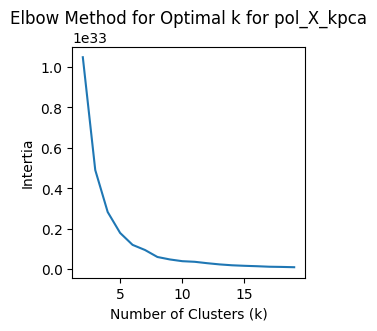

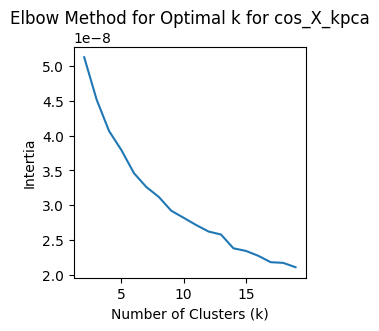

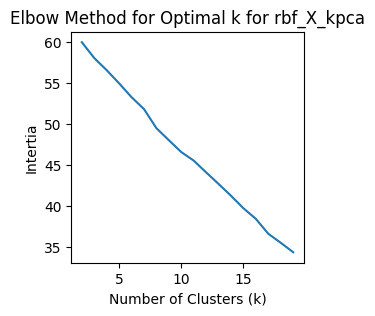

In [29]:
# KMeans Clustering algorithm use
plot_kmeans(df_final,'df_final')
plot_kmeans(embedding_matrix,'embedding_matrix')
plot_kmeans(X_scaled,'X_scaled')
plot_kmeans(X,'X')
plot_kmeans(pol_X_kpca,'pol_X_kpca')
plot_kmeans(cos_X_kpca,'cos_X_kpca')
plot_kmeans(rbf_X_kpca,'rbf_X_kpca')

#### Observation 
- With KMeans rbf doesn't go well maybe need to increase number of clusters.
- Mostly No elbow or very fine Elbow point is discoverd with all type of data.

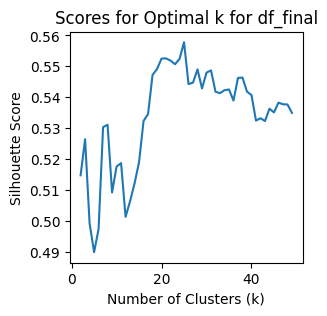

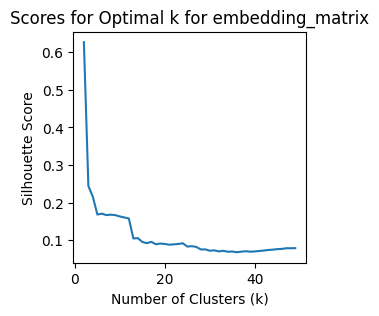

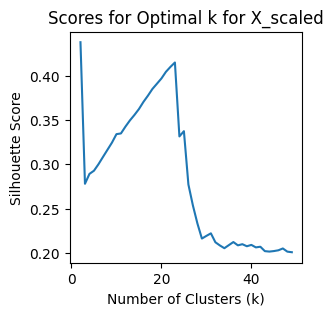

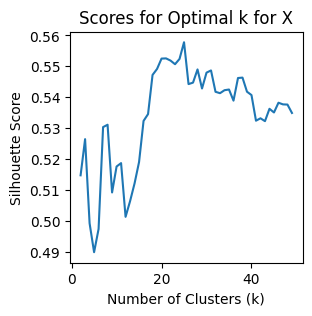

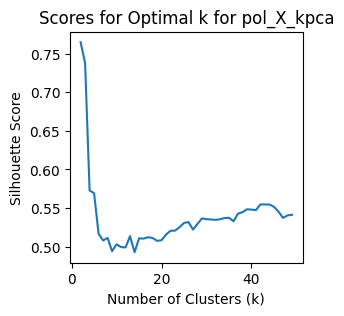

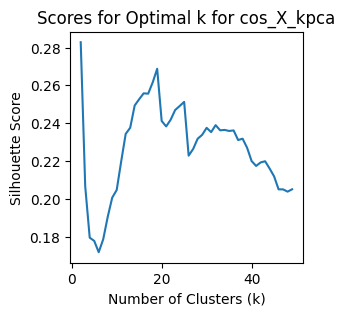

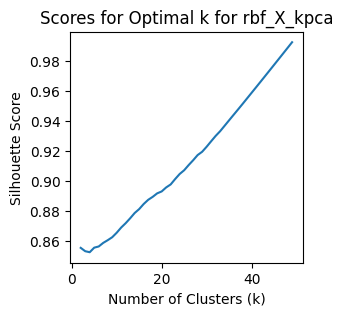

In [35]:
# Agglomerative Clustering Plotting with different scores and n_values.

AgglomerativeClustering_plot(df_final,'df_final')
AgglomerativeClustering_plot(embedding_matrix,'embedding_matrix')
AgglomerativeClustering_plot(X_scaled,'X_scaled')
AgglomerativeClustering_plot(X,'X')
AgglomerativeClustering_plot(pol_X_kpca,'pol_X_kpca')
AgglomerativeClustering_plot(cos_X_kpca,'cos_X_kpca')
AgglomerativeClustering_plot(rbf_X_kpca,'rbf_X_kpca')

#### Observation 

- Again only kpca with kernel **rbf** gives a better score but still the score only goes up with more clustering.
- Reduced dataset with no scaling and non-reduced dataset also worked fine with clustering scores
- X dataset best_n = 23-28 
- final_df best_n = 25-28

In [36]:
DBSCAN_train(df_final,'df_final')
DBSCAN_train(embedding_matrix,'embedding_matrix')
DBSCAN_train(X_scaled,'X_scaled')
DBSCAN_train(X,'X')
DBSCAN_train(pol_X_kpca,'pol_X_kpca')
DBSCAN_train(cos_X_kpca,'cos_X_kpca')
DBSCAN_train(rbf_X_kpca,'rbf_X_kpca')


embedding_matrix Best DBSCAN Params: eps=0.8, min_samples=10, silhouette_score=0.402, Cluster:2

rbf_X_kpca Best DBSCAN Params: eps=0.05, min_samples=5, silhouette_score=0.857, Cluster:2


#### Observation 
- We have again much better results with rbf kernel of kpca, but this time DBSCAN couldn't get the non-linear relationship 

## Key-Findings, Walkthorugh, Summary

- There could be multiple best clusters approach based on need and more data.
- HDBSCAN is best clustering algorithm for this data
- Worked with multiple combination of data pre-processing such as PCA+TruncatedSVD+UMAP, KPCA+UMAP, KPCA with different kernels.
- I used different techniques to catch different features uniquely such as semantic as 1, Numeric as 1, and Categorical as 1, also tried if combination of all would work better or not.
- Worked with multiple clustering algorithm to get the best one out of it, as data has non-linearity I have used DBSCAN,HDBSCAN as it also has categorical data so used tree based algorithm AgglomerativeClustering.
- To work with non-linearity and Kmeans I also used KPCA, UMAP.
- To map in 2D I used MDS, and TSNE like techniques.
- PLotted graph with scores and clusters to understanding visually and have a better decision making.
- HDBSCAN with KPCA and UMAP works well as KPCA and UMAP preserves both clustering and semantic relations and HDBSCAN works well with higher density making it a perfect model for our dataset.

## Best Model To Choose

- Using **HDBSCAN with UMAP reduction technique** give the best clustering result with **11 clusters** and **score = 89.6**

## Future Recommendation and sugesstion
- Could fine tune HDBSCAN, DBSCAN algorithms for better results.
- using KPCA with reduced data using different approaches with HDBSCAN for getting more better clustering results.
- Different distance metrices and scoring algorithm could be used.
- Using Similarity Matrix with these for Song Recommendation System.